<a href="https://colab.research.google.com/github/namwootree/Basic_Skill/blob/main/Unsupervised%20Learning/%ED%95%B8%EC%A6%88%EC%98%A8%20%EB%B9%84%EC%A7%80%EB%8F%84%20%ED%95%99%EC%8A%B5/Ch_13_%EC%8B%9C%EA%B3%84%EC%97%B4_%ED%81%B4%EB%9F%AC%EC%8A%A4%ED%84%B0%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 시계열 클러스터링 접근 방법

* 시계열 클러스터링에 대한 어떤 접근 방법이든 이러한 유형의 왜곡을 처리해야 한다

* 클러스터링은 공간에서 데이터 포인트가 다른 데이터 포인트에 얼마나 가까운지 판단하기 위해 거리 척도에 의존했고, 이를 통해 유사한 데이터들이 서로 구별되면서 동질한 군집으로 함께 그룹화될 수 있다

* 시계열 클러스터링도 이와 유사하게 작동하지만 진폭, 주기, 위상 이동, 수직 이동의 사소한 차이에 관계없이 유사한 시계열 데이터가 그룹화되도록 이동 및 스케일링에 불변하는 거리 척도가 필요하다

# k - Shape

* 스케일링 및 이동에 불변하는 거리 척도를 사용해 시계열 시퀀스를 비교하면서 형상을 유지한다

* 특히, k - Shape는 표준화된 버전의 교차 상관관계를 사용해 군집 중심을 계산한 다음, 모든 반복에서 이런 군집에 시계열 할달ㅇ을 업데이트한다

* k - Shape는 스케일링 및 이동에 불변하는 것 외에도 도메인에 독립적이며, 확장 가능하고 최소한의 파라미터 튜닝을 요구

* k - Shape의 반복적인 개선 절차는 시퀀스 수에 따라 선형적으로 확장된다

# Setting

## Install

In [5]:
!pip install kshape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 875 kB 29.6 MB/s 


In [10]:
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.2 MB 30.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
hdbscan
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp38-cp38-linux_x86_64.whl size=2700871 sha256=c833940dbf648955296f1c1a7c953096203b3b34303390dfa80c8a6abf0e7de3
  Stored in directory: /root/.cache/pip/wheels/76/06/48/527e038689c581cc9e519c73840efdc7473805149e55bd7ffd
Successfully built hdbscan


## Library

In [1]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from os import listdir, walk
from os.path import isfile, join

In [2]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from keras.utils import to_categorical
from sklearn.metrics import adjusted_rand_score
import random

In [11]:
from kshape.core import kshape, zscore
import tslearn
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
import hdbscan

In [13]:
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import LeakyReLU, Reshape, UpSampling2D, Conv2DTranspose
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adam, RMSprop

# ECGFiveDays

## Load Data Set

### Google Drive Mount

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
path_ECG_train = '/content/drive/MyDrive/머신러닝 엔지니어링/핸즈온 비지도 학습/data/UCR_TS_Archive_2015/ECGFiveDays/ECGFiveDays_TRAIN'
path_ECG_test = '/content/drive/MyDrive/머신러닝 엔지니어링/핸즈온 비지도 학습/data/UCR_TS_Archive_2015/ECGFiveDays/ECGFiveDays_TEST'

In [16]:
data_train = np.loadtxt(path_ECG_train, delimiter=',')

X_train = to_time_series_dataset(data_train[:, 1:])
y_train = data_train[:, 0].astype(np.int)

<ipython-input-16-3daf5883f6c6>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = data_train[:, 0].astype(np.int)


In [17]:
data_test = np.loadtxt(path_ECG_test, delimiter=',')

X_test = to_time_series_dataset(data_test[:, 1:])
y_test = data_test[:, 0].astype(np.int)

<ipython-input-17-158c71e3bd1b>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_test = data_test[:, 0].astype(np.int)


## DDA

In [18]:
print("Number of time series:", len(data_train))
print("Number of unique classes:", len(np.unique(data_train[:,0])))
print("Time series length:", len(data_train[0,1:]))

Number of time series: 23
Number of unique classes: 2
Time series length: 136


In [19]:
print("Number of time series in class 1.0:", 
      len(data_train[data_train[:,0]==1.0]))

print("Number of time series in class 2.0:", 
      len(data_train[data_train[:,0]==2.0]))

Number of time series in class 1.0: 14
Number of time series in class 2.0: 9


Plot  0  Class  1.0


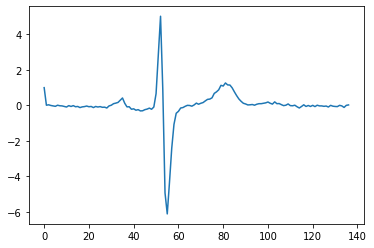

Plot  1  Class  1.0


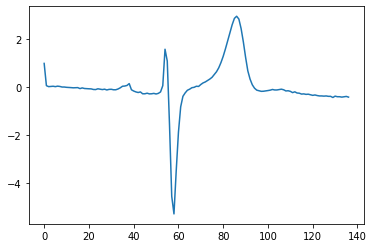

Plot  4  Class  1.0


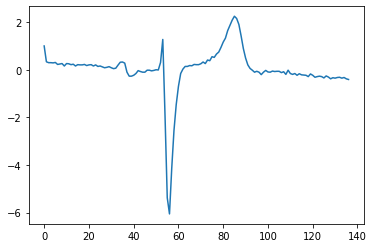

Plot  7  Class  1.0


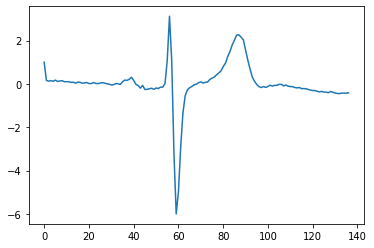

Plot  9  Class  1.0


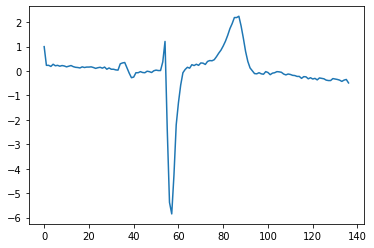

In [24]:
for i in range(0,10):
    if data_train[i,0]==1.0:
        print("Plot ",i," Class ",data_train[i,0])
        plt.plot(data_train[i])
        plt.show()

Plot  2  Class  2.0


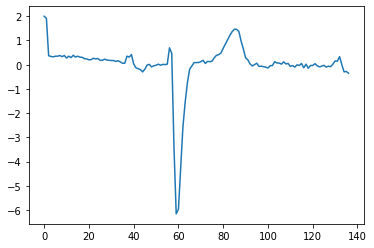

Plot  3  Class  2.0


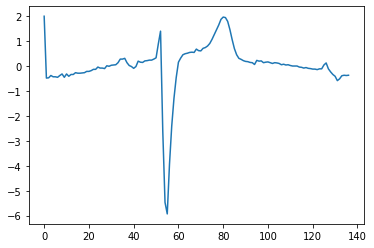

Plot  5  Class  2.0


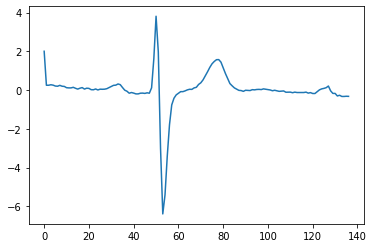

Plot  6  Class  2.0


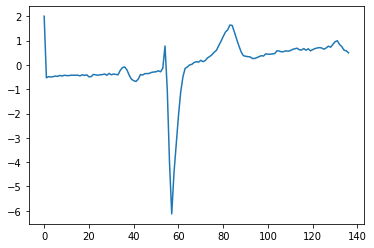

Plot  8  Class  2.0


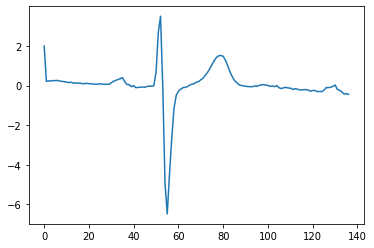

In [25]:
for i in range(0,10):
    if data_train[i,0]==2.0:
        print("Plot ",i," Class ",data_train[i,0])
        plt.plot(data_train[i])
        plt.show()

## 스케링링

In [27]:
X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_train)
X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_test)

## k - Shape

In [28]:
ks = KShape(n_clusters=2, max_iter=100, n_init=100,verbose=0)
ks.fit(X_train)

KShape(n_clusters=2, n_init=100, verbose=0)

### 수정된 Rand 지수

* 우연히 그룹화된 성분에 대한 조정된 두 데이터 군집 간 유사도 척도

* 직관적으로 Rand 지수는 예측 군집과 실제 군집 사이의 군집 할당에서 일치하는 개수를 측정한다

* 모델의 수정된 Rand 지수 값이 0.0에 가까운 경우 순전히 무작위로 군집을 할당한 것이다

* 반대로 모델의 수정된 Rand 지수 값이 1.0에 가까운 경우 예측 군집과 실제 군집이 정확하게 일치한 것이다

In [30]:
# 훈련 셋의 예측값 생성 및 수정된 Rand 지수 계산
preds = ks.predict(X_train)
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index:", ars)

Adjusted Rand Index: 0.668041237113402


In [31]:
# 테스트 셋의 예측값 생성 및 수정된 Rand 지수 계산
preds_test = ks.predict(X_test)
ars = adjusted_rand_score(data_test[:,0],preds_test)
print("Adjusted Rand Index on Test Set:", ars)

Adjusted Rand Index on Test Set: 0.0013631814413340424


# ECG5000

## Load Data Set

In [32]:
path_ECG_train = '/content/drive/MyDrive/머신러닝 엔지니어링/핸즈온 비지도 학습/data/UCR_TS_Archive_2015/ECG5000/ECG5000_TRAIN'
path_ECG_test = '/content/drive/MyDrive/머신러닝 엔지니어링/핸즈온 비지도 학습/data/UCR_TS_Archive_2015/ECG5000/ECG5000_TEST'

In [33]:
data_train = np.loadtxt(path_ECG_train, delimiter=',')
data_test = np.loadtxt(path_ECG_test, delimiter=',')

In [34]:
data_joined = np.concatenate([data_train,data_test], axis=0)

In [35]:
data_train, data_test = train_test_split(data_joined, 
                                         test_size=0.20, 
                                         random_state=2022)

In [36]:
X_train = to_time_series_dataset(data_train[:, 1:])
y_train = data_train[:, 0].astype(np.int)
X_test = to_time_series_dataset(data_test[:, 1:])
y_test = data_test[:, 0].astype(np.int)

<ipython-input-36-61fa4f6705bc>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = data_train[:, 0].astype(np.int)
<ipython-input-36-61fa4f6705bc>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20

## DDA

In [37]:
print("Number of time series:", len(data_train))
print("Number of unique classes:", len(np.unique(data_train[:,0])))
print("Time series length:", len(data_train[0,1:]))

Number of time series: 4000
Number of unique classes: 5
Time series length: 140


In [38]:
print("Number of time series in class 1.0:", 
      len(data_train[data_train[:,0]==1.0]))

print("Number of time series in class 2.0:", 
      len(data_train[data_train[:,0]==2.0]))

print("Number of time series in class 3.0:", 
      len(data_train[data_train[:,0]==3.0]))

print("Number of time series in class 4.0:", 
      len(data_train[data_train[:,0]==4.0]))

print("Number of time series in class 5.0:", 
      len(data_train[data_train[:,0]==5.0]))

Number of time series in class 1.0: 2333
Number of time series in class 2.0: 1410
Number of time series in class 3.0: 80
Number of time series in class 4.0: 161
Number of time series in class 5.0: 16


 Class  1.0  Count  2333


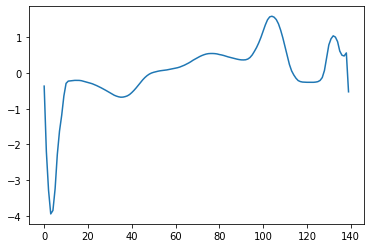

 Class  2.0  Count  1410


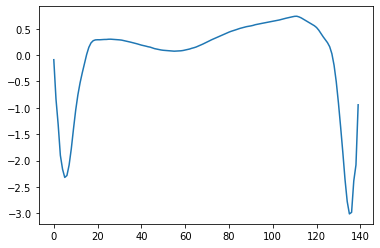

 Class  3.0  Count  80


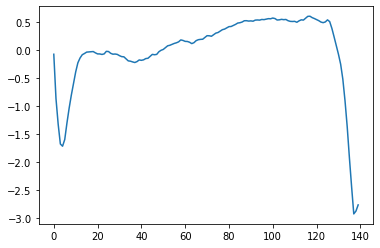

 Class  4.0  Count  161


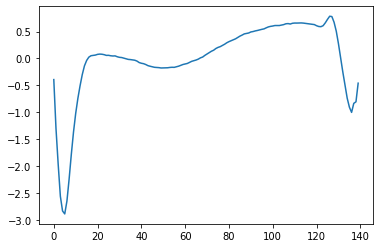

 Class  5.0  Count  16


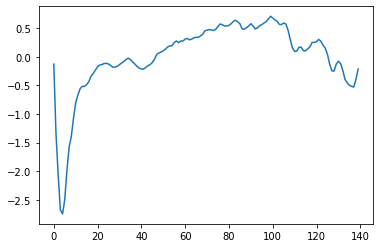

In [39]:
for j in np.unique(data_train[:,0]):
    dataPlot = data_train[data_train[:,0]==j]
    cnt = len(dataPlot)
    dataPlot = dataPlot[:,1:].mean(axis=0)
    print(" Class ",j," Count ",cnt)
    plt.plot(dataPlot)
    plt.show()

## 스케일링

In [40]:
X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_train)
X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_test)

## k - Shape

In [42]:
ks = KShape(n_clusters=5, max_iter=100, n_init=10,verbose=1,random_state=2022)
ks.fit(X_train)

Init 1
0.017 --> 0.017 --> 
Init 2
0.015 --> 0.015 --> 
Init 3
0.016 --> 0.016 --> 0.017 --> 
Init 4
0.018 --> 0.018 --> 0.017 --> 0.018 --> 
Init 5
0.018 --> 0.017 --> 0.017 --> 
Init 6
0.035 --> 0.020 --> 0.016 --> 0.016 --> 
Init 7
0.015 --> 0.014 --> 0.014 --> 
Init 8
0.016 --> 0.015 --> 0.016 --> 
Init 9
0.014 --> 0.014 --> 
Init 10
0.016 --> 0.017 --> 


KShape(n_clusters=5, n_init=10, random_state=2022, verbose=1)

## 수정된 Rand 지수

In [44]:
# 훈련 셋에 대한 예측값 생성 및 수정된 Rand 지수 계산
preds = ks.predict(X_train)
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index on Training Set:", ars)

Adjusted Rand Index on Training Set: 0.45300355956290145


In [45]:
# 테스트 셋에 대한 예측값 생성 및 수정된 Rand 지수 계산
preds_test = ks.predict(X_test)
ars = adjusted_rand_score(data_test[:,0],preds_test)
print("Adjusted Rand Index on Test Set:", ars)

Adjusted Rand Index on Test Set: 0.46701335238549235


## 군집별 적합도 검정

In [46]:
preds_test = np.hstack((preds_test.reshape(1000,1),
                        data_test[:,0].reshape(1000,1)))

preds_test = pd.DataFrame(data=preds_test)
preds_test = preds_test.rename(columns={0: 'prediction', 1: 'actual'})

In [47]:
counter = 0
for i in np.sort(preds_test.prediction.unique()):

    print("Predicted Cluster ", i)
    print(preds_test.actual[preds_test.prediction==i].value_counts())
    print()

    cnt = preds_test.actual[preds_test.prediction==i].value_counts().iloc[1:].sum()
    counter = counter + cnt
    
print("Count of Non-Primary Points: ", counter)

Predicted Cluster  0.0
1.0    84
2.0     8
3.0     4
4.0     1
5.0     1
Name: actual, dtype: int64

Predicted Cluster  1.0
1.0    330
3.0      2
5.0      1
4.0      1
Name: actual, dtype: int64

Predicted Cluster  2.0
2.0    317
4.0     12
1.0      8
3.0      8
5.0      4
Name: actual, dtype: int64

Predicted Cluster  3.0
2.0    31
4.0    17
1.0     7
5.0     1
Name: actual, dtype: int64

Predicted Cluster  4.0
1.0    157
3.0      2
4.0      2
5.0      1
2.0      1
Name: actual, dtype: int64

Count of Non-Primary Points:  81


## 시계열 k - 평균

In [48]:
km = TimeSeriesKMeans(n_clusters=5,
                      max_iter=100,
                      n_init=100,
                      metric="euclidean",
                      verbose=1,
                      random_state=2022)
km.fit(X_train)

Init 1
35.465 --> 25.232 --> 24.645 --> 24.426 --> 24.328 --> 24.284 --> 24.268 --> 24.262 --> 24.257 --> 24.255 --> 24.254 --> 24.253 --> 24.252 --> 24.252 --> 24.251 --> 24.250 --> 24.250 --> 24.250 --> 24.250 --> 24.250 --> 
Init 2
34.736 --> 26.448 --> 25.633 --> 24.923 --> 24.563 --> 24.435 --> 24.377 --> 24.331 --> 24.297 --> 24.279 --> 24.269 --> 24.266 --> 24.264 --> 24.262 --> 24.260 --> 24.259 --> 24.258 --> 24.258 --> 24.257 --> 24.257 --> 24.257 --> 24.256 --> 24.256 --> 24.255 --> 24.255 --> 24.255 --> 24.254 --> 24.254 --> 24.254 --> 24.254 --> 
Init 3
36.609 --> 25.450 --> 24.969 --> 24.786 --> 24.691 --> 24.626 --> 24.585 --> 24.559 --> 24.540 --> 24.517 --> 24.494 --> 24.471 --> 24.441 --> 24.413 --> 24.377 --> 24.346 --> 24.318 --> 24.305 --> 24.295 --> 24.286 --> 24.277 --> 24.266 --> 24.255 --> 24.246 --> 24.239 --> 24.232 --> 24.229 --> 24.228 --> 24.227 --> 24.227 --> 24.227 --> 24.226 --> 24.226 --> 24.226 --> 24.226 --> 24.226 --> 24.226 --> 
Init 4
32.347 --> 2

TimeSeriesKMeans(max_iter=100, n_clusters=5, n_init=100, random_state=2022,
                 verbose=1)

In [49]:
# 훈련 셋에 대한 예측값 생성 및 수정된 Rand 지수를 사용한 평가
preds = km.predict(X_train)
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index of Time Series k-Means on Training Set:", ars)

Adjusted Rand Index of Time Series k-Means on Training Set: 0.5038220789593691


In [50]:
# 테스트 셋에 대한 예측값 생성 및 수정된 Rand 지수를 사용한 평가
preds_test = km.predict(X_test)
ars = adjusted_rand_score(data_test[:,0],preds_test)
print("Adjusted Rand Index of Time Series k-Means on Test Set:", ars)

Adjusted Rand Index of Time Series k-Means on Test Set: 0.4981689037079987


## HDBCAN

In [51]:
min_cluster_size = 5
min_samples = None
alpha = 1.0
cluster_selection_method = 'eom'
prediction_data = True

In [52]:
hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                      min_samples=min_samples,
                      alpha=alpha,
                      cluster_selection_method=cluster_selection_method,
                      prediction_data=prediction_data)

In [53]:
# 훈련 모델 및 테스트 셋에 대한 평가
preds = hdb.fit_predict(X_train.reshape(4000,140))
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index on Training Set:", ars)

Adjusted Rand Index on Training Set: 0.7632276348317126


In [54]:
# 테스트 셋에 대한 예측값 생성 및 평가
preds_test = hdbscan.prediction.approximate_predict(hdb, X_test.reshape(1000,140))
ars = adjusted_rand_score(data_test[:,0],preds_test[0])
print("Adjusted Rand Index on Test Set:", ars)

Adjusted Rand Index on Test Set: 0.7506690137977234


# 시계열 클러스터링 알고리즘 비교

In [68]:
current_path = os.getcwd()
file = os.path.sep.join(['',
                         'drive',
                         'MyDrive',
                         '머신러닝 엔지니어링',
                         '핸즈온 비지도 학습',
                         'data',
                         'UCR_TS_Archive_2015',
                         ''])

mypath = current_path + file

print(mypath)

/content/drive/MyDrive/머신러닝 엔지니어링/핸즈온 비지도 학습/data/UCR_TS_Archive_2015/


In [70]:
d = []
f = []

for (dirpath, dirnames, filenames) in walk(mypath):

  for i in dirnames:

    newpath = os.path.sep.join([mypath, i, ''])
    onlyfiles = [f for f in listdir(newpath) if isfile(join(newpath, f))]
    f.extend(onlyfiles)
  
  d.extend(dirnames)
  break

In [76]:
class ElapsedTimer(object):
  
    def __init__(self):

        self.start_time = time.time()

    def elapsed(self,sec):

        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"

    def elapsed_time(self):
      
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time))
        return (time.time() - self.start_time)

## k - Shape

In [77]:
kShapeDF = pd.DataFrame(data=[],
                        index=[v for v in d],
                        columns=["Train ARS","Test ARS"])

In [78]:
timer = ElapsedTimer()

cnt = 0

for i in d:
    cnt += 1
    print("Dataset ", cnt)
    newpath = os.path.sep.join([mypath, i, ""])
    onlyfiles = [f for f in listdir(newpath) if isfile(join(newpath, f))]
    j = onlyfiles[0]
    k = onlyfiles[1]
    data_train = np.loadtxt(newpath+j, delimiter=",")
    data_test = np.loadtxt(newpath+k, delimiter=",")

    data_joined = np.concatenate((data_train,data_test),axis=0)
    data_train, data_test = train_test_split(data_joined, \
                                        test_size=0.20, random_state=2019)

    X_train = to_time_series_dataset(data_train[:, 1:])
    y_train = data_train[:, 0].astype(np.int)
    X_test = to_time_series_dataset(data_test[:, 1:])
    y_test = data_test[:, 0].astype(np.int)
    
    X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.) \
                                .fit_transform(X_train)
    X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.) \
                                .fit_transform(X_test)
    
    classes = len(np.unique(data_train[:,0]))
    ks = KShape(n_clusters=classes, max_iter=10, n_init=3,verbose=0)
    ks.fit(X_train)

    print(i)
    preds = ks.predict(X_train)
    ars = adjusted_rand_score(data_train[:,0],preds)
    print("Adjusted Rand Index on Training Set:", ars)
    kShapeDF.loc[i,"Train ARS"] = ars
    
    preds_test = ks.predict(X_test)
    ars = adjusted_rand_score(data_test[:,0],preds_test)
    print("Adjusted Rand Index on Test Set:", ars)
    kShapeDF.loc[i,"Test ARS"] = ars
    
kShapeTime = timer.elapsed_time()

Dataset  1


<ipython-input-78-a1f65e818a89>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = data_train[:, 0].astype(np.int)
<ipython-input-78-a1f65e818a89>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.

HandOutlines
Adjusted Rand Index on Training Set: 0.1989281211626428
Adjusted Rand Index on Test Set: 0.17072528248490174
Dataset  2


<ipython-input-78-a1f65e818a89>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = data_train[:, 0].astype(np.int)
<ipython-input-78-a1f65e818a89>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.

LargeKitchenAppliances
Adjusted Rand Index on Training Set: 0.2582128432300119
Adjusted Rand Index on Test Set: 0.17146763997093142
Dataset  3


<ipython-input-78-a1f65e818a89>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = data_train[:, 0].astype(np.int)
<ipython-input-78-a1f65e818a89>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.

KeyboardInterrupt: ignored

## k - 평균

In [ ]:
kMeansDF = pd.DataFrame(data=[],
                        index=[v for v in d], 
                        columns=["Train ARS","Test ARS"])

In [ ]:
timer = ElapsedTimer()

cnt = 0

for i in d:
    cnt += 1
    print("Dataset ", cnt)
    newpath = os.path.sep.join([mypath, i, ""])
    onlyfiles = [f for f in listdir(newpath) if isfile(join(newpath, f))]
    j = onlyfiles[0]
    k = onlyfiles[1]
    data_train = np.loadtxt(newpath+j, delimiter=",")
    data_test = np.loadtxt(newpath+k, delimiter=",")

    data_joined = np.concatenate((data_train,data_test),axis=0)
    data_train, data_test = train_test_split(data_joined, \
                                        test_size=0.20, random_state=2019)

    X_train = to_time_series_dataset(data_train[:, 1:])
    y_train = data_train[:, 0].astype(np.int)
    X_test = to_time_series_dataset(data_test[:, 1:])
    y_test = data_test[:, 0].astype(np.int)
    
    X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.) \
                                    .fit_transform(X_train)
    X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.) \
                                    .fit_transform(X_test)
    
    classes = len(np.unique(data_train[:,0]))
    km = TimeSeriesKMeans(n_clusters=5, max_iter=10, n_init=10, \
                          metric="euclidean", verbose=0, random_state=2019)
    km.fit(X_train)

    print(i)
    preds = km.predict(X_train)
    ars = adjusted_rand_score(data_train[:,0],preds)
    print("Adjusted Rand Index on Training Set:", ars)
    kMeansDF.loc[i,"Train ARS"] = ars
    
    preds_test = km.predict(X_test)
    ars = adjusted_rand_score(data_test[:,0],preds_test)
    print("Adjusted Rand Index on Test Set:", ars)
    kMeansDF.loc[i,"Test ARS"] = ars
    
kMeansTime = timer.elapsed_time()

## HDBSCAN

In [ ]:
hdbscanDF = pd.DataFrame(data=[],
                         index=[v for v in d],
                         columns=["Train ARS","Test ARS"])

In [ ]:
timer = ElapsedTimer()

cnt = 0

for i in d:
    cnt += 1
    print("Dataset ", cnt)
    newpath = os.path.sep.join([mypath, i, ""])
    onlyfiles = [f for f in listdir(newpath) if isfile(join(newpath, f))]
    j = onlyfiles[0]
    k = onlyfiles[1]
    data_train = np.loadtxt(newpath+j, delimiter=",")
    data_test = np.loadtxt(newpath+k, delimiter=",")

    data_joined = np.concatenate((data_train,data_test),axis=0)
    data_train, data_test = train_test_split(data_joined, \
                                    test_size=0.20, random_state=2019)

    X_train = data_train[:, 1:]
    y_train = data_train[:, 0].astype(np.int)
    X_test = data_test[:, 1:]
    y_test = data_test[:, 0].astype(np.int)
    
    X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.) \
                                    .fit_transform(X_train)
    X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.)  \
                                    .fit_transform(X_test)
    
    classes = len(np.unique(data_train[:,0]))
    min_cluster_size = 5
    min_samples = None
    alpha = 1.0
    cluster_selection_method = 'eom'
    prediction_data = True

    hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, \
                          min_samples=min_samples, alpha=alpha, \
                          cluster_selection_method= \
                              cluster_selection_method, \
                          prediction_data=prediction_data)

    print(i)
    preds = hdb.fit_predict(X_train.reshape(X_train.shape[0], \
                                            X_train.shape[1]))
    ars = adjusted_rand_score(data_train[:,0],preds)
    print("Adjusted Rand Index on Training Set:", ars)
    hdbscanDF.loc[i,"Train ARS"] = ars
    
    preds_test = hdbscan.prediction.approximate_predict(hdb, 
                            X_test.reshape(X_test.shape[0], \
                                           X_test.shape[1]))
    ars = adjusted_rand_score(data_test[:,0],preds_test[0])
    print("Adjusted Rand Index on Test Set:", ars)
    hdbscanDF.loc[i,"Test ARS"] = ars
    
hdbscanTime = timer.elapsed_time()

## 세가지 실험에 대한 모두 비교

In [ ]:
print("k-Shape Results")
kShapeDF.mean()

In [ ]:
print("k-Means Results")
kMeansDF.mean()

In [ ]:
print("HDBSCAN Results")
hdbscanDF.mean()

In [ ]:
# 모든 데이터 셋별 세가지 알고리즘을 적용한 수정된 Rand 지수 상위 순위 계산
timeSeriesClusteringDF = pd.DataFrame(data=[],index=kShapeDF.index, \
                            columns=["kShapeTest", \
                                    "kMeansTest", \
                                    "hdbscanTest"])

timeSeriesClusteringDF.kShapeTest = kShapeDF["Test ARS"]
timeSeriesClusteringDF.kMeansTest = kMeansDF["Test ARS"]
timeSeriesClusteringDF.hdbscanTest = hdbscanDF["Test ARS"]

tscResults = timeSeriesClusteringDF.copy()

for i in range(0,len(tscResults)):
    maxValue = tscResults.iloc[i].max()
    tscResults.iloc[i][tscResults.iloc[i]==maxValue]=1
    minValue = tscResults .iloc[i].min()
    tscResults.iloc[i][tscResults.iloc[i]==minValue]=-1
    medianValue = tscResults.iloc[i].median()
    tscResults.iloc[i][tscResults.iloc[i]==medianValue]=0

In [ ]:
tscResultsDF = pd.DataFrame(data=np.zeros((3,3)), \
                index=["firstPlace","secondPlace","thirdPlace"], \
                columns=["kShape", "kMeans","hdbscan"])
tscResultsDF.loc["firstPlace",:] = tscResults[tscResults==1].count().values
tscResultsDF.loc["secondPlace",:] = tscResults[tscResults==0].count().values
tscResultsDF.loc["thirdPlace",:] = tscResults[tscResults==-1].count().values
tscResultsDF